# Perceptron Classification: Offensive vs Defensive Players

## What is a Perceptron?
The perceptron is a simple linear binary classification model. It works by:
1. Taking input features and their corresponding weights
2. Computing a weighted sum
3. Applying a step function to produce a binary output

## Our Task
We'll use a perceptron to classify EA FC 24 players as either offensive or defensive based on their attributes. This binary classification task will demonstrate the perceptron's ability to find a linear decision boundary between two classes.

## Implementation

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

class Perceptron(object):
    def __init__(self, eta=.5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        self.w_ = np.random.rand(1 + X.shape[1])
        
        self.errors_ = []
        
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (self.predict(xi) - target)
                self.w_[:-1] -= update*xi
                self.w_[-1] -= update
                errors += int(update != 0)
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[:-1]) + self.w_[-1]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

## Understanding Our Dataset
Let's examine the key attributes we'll use to distinguish between offensive and defensive players:
- Shooting, Pace, Dribbling (typically higher for offensive players)
- Defending, Physical (typically higher for defensive players)

We would use all 5 attributes to train our model.

At first glance, it might seem like an easy decision for high rated players. However, the dataset also includes low rated players with ratings closer together in the 40-60 range. This makes it more difficult to distinguish between offensive and defensive players.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

players_df = pd.read_csv("../data/players_data.csv")

# Define offensive and defensive positions
offensive_positions = ['ST', 'CF', 'LW', 'RW', 'CAM']
defensive_positions = ['CB', 'LB', 'RB', 'CDM', 'LWB', 'RWB']

# Create target variable (1 for offensive, -1 for defensive)
def get_position_class(position_str):
	positions = str(position_str).split(', ')
	if any(pos in offensive_positions for pos in positions):
		return 1
	elif any(pos in defensive_positions for pos in positions):
		return -1
	return None

# Prepare the data
players_df['position_class'] = players_df['player_positions'].apply(get_position_class)

# Filter only offensive and defensive players. We'll remove ambiguous players.
filtered_df = players_df[players_df['position_class'].notna()]

features = ["shooting", "defending", "pace", "dribbling", "physic"]
# Select features for classification
X = filtered_df[features].values
y = filtered_df['position_class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

(4433, 5) (4433,)


/var/folders/pz/s1ggtx853xx_qxny9g89ffgm0000gn/T/ipykernel_15826/2527139486.py:4: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  players_df = pd.read_csv("../data/players_data.csv")


## Model Training

In [ ]:
# Set the Seaborn theme
sns.set_theme()

# Instantiate and train the perceptron
clf = Perceptron(epochs=1000)
clf.train(X_train, y_train)



## Most Weighted Features
From our model, what were the most important features?

As hypothesized, shooting and defending would be the strongest features. However, we also see that dribbling is almost as important as those two. This perhaps becomes more important in distinguishing players whose ratings are closer together.

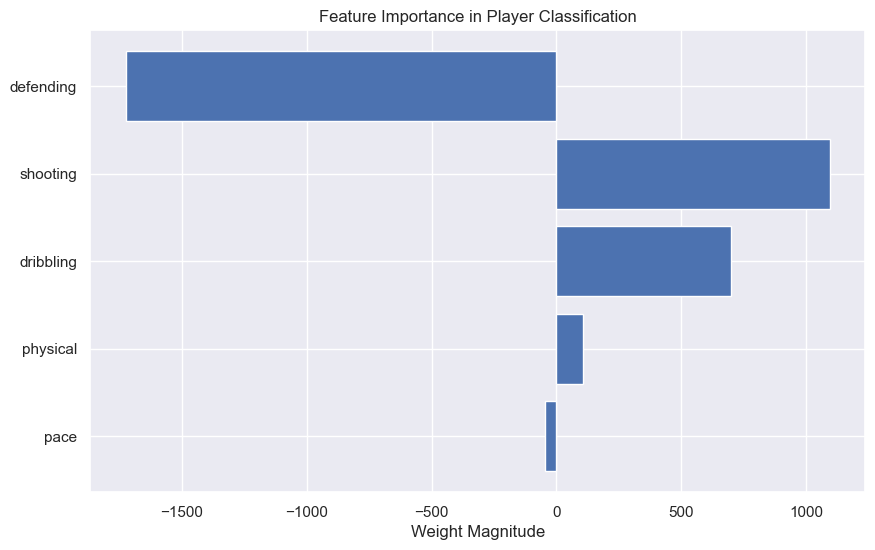

In [ ]:
# 1. Feature importance plot
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'Feature': ['shooting', 'defending', 'pace', 'dribbling', 'physical'],
    'Weight': clf.w_[:-1]  # excluding bias weight
})
feature_importance = feature_importance.sort_values('Weight', ascending=True, key=abs)

plt.barh(feature_importance['Feature'], feature_importance['Weight'])
plt.title('Feature Importance in Player Classification')
plt.xlabel('Weight Magnitude')
plt.show()

## Model Performance Evaluation

Let's take a look at our accuracy and confusion matrix

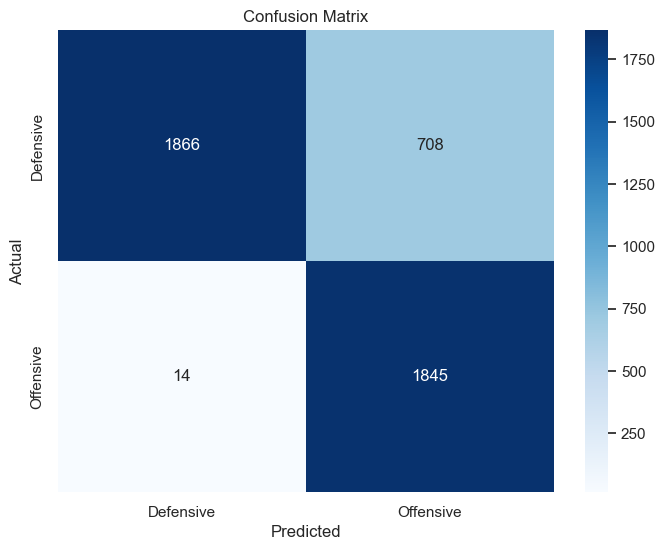


Classification Report:
              precision    recall  f1-score   support

   Defensive       0.99      0.72      0.84      2574
   Offensive       0.72      0.99      0.84      1859

    accuracy                           0.84      4433
   macro avg       0.86      0.86      0.84      4433
weighted avg       0.88      0.84      0.84      4433



In [ ]:
# Calculate and display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

y_hat = clf.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_hat)

# Create labels for the classes
class_labels = ['Defensive', 'Offensive']

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification metrics
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_hat, target_names=class_labels))



## Actual Scatter Plot vs Predicted Scatter Plot

We can see that the overall trend is captured, however, as pointed out in the confusion matrix, we have falsely labelled a bunch of defensive players as offensive.

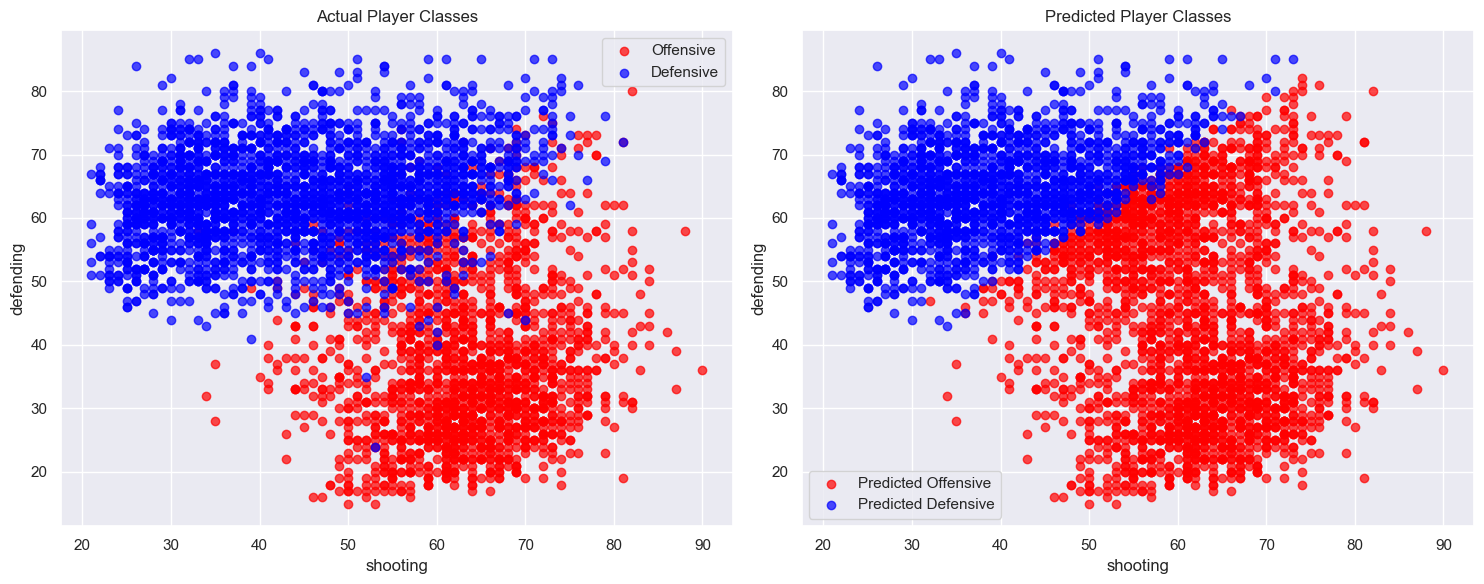

In [ ]:
# Create two subplots side by side
plt.figure(figsize=(15, 6))

# First subplot - Actual classes
plt.subplot(1, 2, 1)
top_features = feature_importance.tail(2)['Feature'].values

# Plot actual offensive players (y_test == 1) in red
plt.scatter(X_test[y_test == 1, 0], 
           X_test[y_test == 1, 1],
           label='Offensive', alpha=0.7, color='red')

# Plot actual defensive players (y_test == -1) in blue
plt.scatter(X_test[y_test == -1, 0], 
           X_test[y_test == -1, 1],
           label='Defensive', alpha=0.7, color='blue')

plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title('Actual Player Classes')
plt.legend()

# Second subplot - Predicted classes
plt.subplot(1, 2, 2)

# Plot predicted offensive players (y_hat == 1) in red
plt.scatter(X_test[y_hat == 1, 0], 
           X_test[y_hat == 1, 1],
           label='Predicted Offensive', alpha=0.7, color='red')

# Plot predicted defensive players (y_hat == -1) in blue
plt.scatter(X_test[y_hat == -1, 0], 
           X_test[y_hat == -1, 1],
           label='Predicted Defensive', alpha=0.7, color='blue')

plt.xlabel(top_features[0])
plt.ylabel(top_features[1])
plt.title('Predicted Player Classes')
plt.legend()

plt.tight_layout()
plt.show()